Os dados foram obtidos através do site https://ceb.nlm.nih.gov/repositories/malaria-datasets. No qual possui imagens reais de individuos que foram infectados com malária e não infectados. Desta forma, pretende-se criar um modelo CNN que possa através de uma nova imagem, realizar a descriminação entre infectado e não infectado. Desta forma, pretende-se criar uma ferramenta capaz de auxiliar a detecção desta doença.

In [216]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [218]:
my_data_dir = '/content/drive/MyDrive/colab_notebooks/projetos/classificacao_de_imagem_cnn/cell_images'

In [219]:
test_path = os.path.join(my_data_dir, 'test')
train_path = os.path.join(my_data_dir, 'train')

In [220]:
para_cell = os.path.join(train_path, 'cell_images/parasitized')

In [221]:
test_path = my_data_dir+'//test//'
train_path = my_data_dir+'//train//'

In [222]:
para_cell = train_path+'//parasitized'+'//C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [223]:
para_img= imread(para_cell)

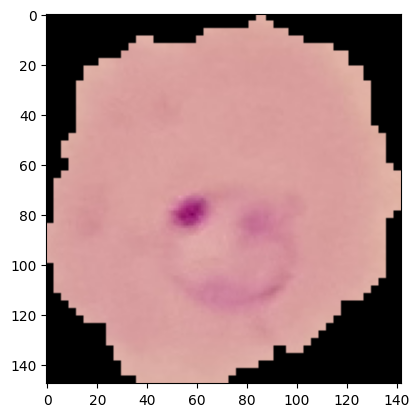

In [224]:
plt.imshow(para_img)

In [225]:
para_img.shape

(148, 142, 3)

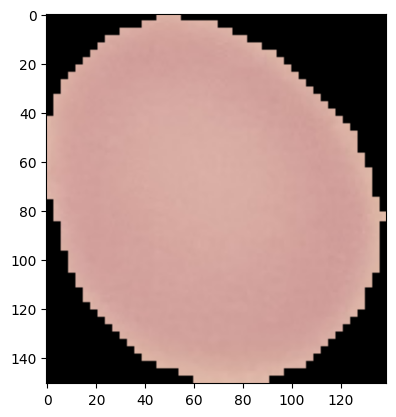

In [226]:
unifected_cell_path = train_path+'//uninfected//'+os.listdir(train_path+'//uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

Checando a quantidade de imagens:

In [227]:
len(os.listdir(os.path.join(train_path,'parasitized')))

12509

In [228]:
unifected_cell.shape

(151, 139, 3)

In [229]:
len(os.listdir(os.path.join(train_path,'uninfected')))

12490

In [230]:
para_img.shape

(148, 142, 3)

In [231]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'//uninfected'):

    img = imread(test_path+'//uninfected'+'//'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

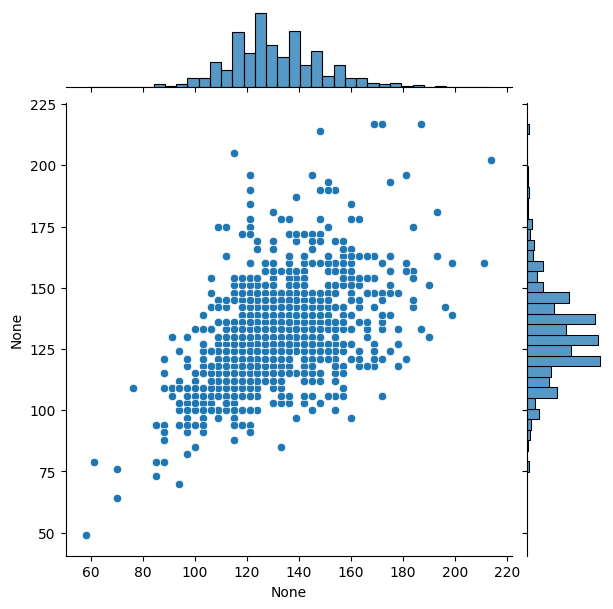

In [232]:
sns.jointplot(x=dim1, y=dim2)

In [233]:
np.mean(dim1)

np.float64(130.92538461538462)

In [234]:
np.mean(dim2)

np.float64(130.75)

In [235]:
image_shape=(130,130,3)

Preparação dos dados para modelagem

Existe muitas imagens para serem lidas todas de uma vez, desta forma, utilizaremos funções do módulo Keras para processar os dados automatimanete, gerar um fluxo do diretório e manipular as imagens.

In [236]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.legacy.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |
 |  DEPRECATED.
 |
 |  Methods defined here:
 |
 |  __init__(self, featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=

In [237]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range = 0.1, #rotaciona a imagem em 20°
                               height_shift_range=0.10, # aumenta a altura da imagem em no máximo 5%
                               rescale=1/255, # Redimensione a imagem normalizando-a.
                               shear_range=0.1, # corta parte da imagem (máximo 10%)
                               zoom_range=0.1, # Zoom de no maximo 10%
                               horizontal_flip=True, # permite o giro horizontal
                               fill_mode='nearest' # Preenche os pixels faltantes com o valor preenchido mais próximo
                              )

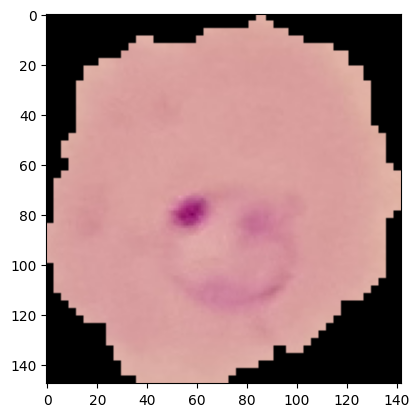

In [238]:
plt.imshow(para_img)

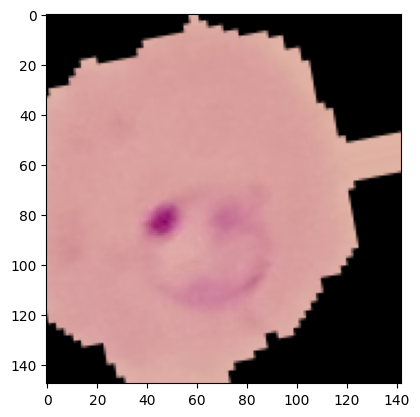

In [239]:
plt.imshow(image_gen.random_transform(para_img))

Gerando várias imagens manipuladas a partir de um diretório

Para usar .flow_from_directory, deve-se organizar as imagens em subdiretórios. Os diretórios devem conter apenas imagens de uma classe, ou seja, uma pasta por classe de imagens.

Estrutura necessária:

* Pasta de dados da imagem
* Classe 1
  * 0.jpg
  * 1.jpg
  * ...
* Classe 2
  * 0.jpg
  * 1.jpg
  * ...
* ...
* Classe n

In [240]:
image_gen.flow_from_directory(train_path)

Found 24997 images belonging to 2 classes.


In [241]:
image_gen.flow_from_directory(test_path)

Found 2594 images belonging to 2 classes.


Criando o modelo

In [242]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Os dropouts ajudam a reduzir o overfitting ao desligar aleatoriamente os neurônios durante o treinamento.
# Aqui dizemos que desligamos aleatoriamente 50% dos neurônios.
model.add(Dropout(0.5))

# Última camada, dados binários então utiliza-se ativação sigmóide
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [243]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,209 (6.34 MB)

 Trainable params: 1,662,209 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [244]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

Treinando modelo

In [245]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.src.legacy.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.src.legacy.preprocessing.image.ImageDataGenerator instance



In [246]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24997 images belonging to 2 classes.


In [247]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2594 images belonging to 2 classes.


In [248]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [249]:
#O treinamento do modelo foi feito fora do google colab.
#results = model.fit(train_image_gen, epochs=20, validation_data=test_image_gen, callbacks=[early_stop])

In [250]:
with open('/content/drive/MyDrive/colab_notebooks/projetos/classificacao_de_imagem_cnn/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

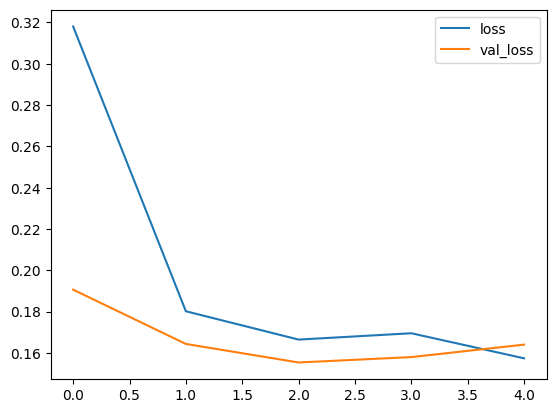

In [251]:
losses = pd.DataFrame(history)
losses[['loss','val_loss']].plot()
plt.show()

In [252]:
model.metrics_names

['loss', 'compile_metrics']

In [253]:
model.evaluate(test_image_gen)

163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 276ms/step - accuracy: 0.2802 - loss: 0.6998


[0.6927947998046875, 0.5096376538276672]

In [254]:
pred_probabilities = model.predict(test_image_gen)

163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step


In [255]:
pred_probabilities

array([[0.50960654],
       [0.5108119 ],
       [0.50473166],
       ...,
       [0.50518334],
       [0.5052289 ],
       [0.50865316]], dtype=float32)

In [256]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [257]:
predictions = pred_probabilities > 0.5

In [258]:
predictions

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [270]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.51      0.18      0.26      1294
           1       0.50      0.83      0.63      1300

    accuracy                           0.50      2594
   macro avg       0.51      0.50      0.44      2594
weighted avg       0.51      0.50      0.45      2594



In [271]:
confusion_matrix(test_image_gen.classes, predictions)

array([[ 229, 1065],
       [ 221, 1079]])

Prevendo uma imagem

In [261]:
my_image = image.load_img(para_cell, target_size=image_shape)

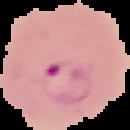

In [262]:
my_image

In [263]:
my_image = image.img_to_array(my_image)

In [264]:
type(my_image)

numpy.ndarray

In [265]:
my_image.shape

(130, 130, 3)

In [266]:
my_image = np.expand_dims(my_image, axis=0)

In [267]:
model.predict(my_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


array([[0.9999892]], dtype=float32)